## Random forest

In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,train_test_split,cross_validate, ShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,average_precision_score,mean_absolute_error,r2_score,confusion_matrix,classification_report
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import LinearSVC
import textwrap
from sklearn.decomposition import NMF,PCA
from itertools import product



In [3]:
dataset=pd.read_csv("dataEncode.csv")

## Metricas

In [4]:
x=dataset.drop(["DiasEstanciaClinica_exactoLog"],axis=1)
y=dataset["DiasEstanciaClinica_exactoLog"].values

In [6]:
def train_test_evaluate(model_name, model, X_train, y_train, X_test, y_test):  
    
    y_pred= model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    r2 = r2_score(y_test, y_pred)
    y_test_mean= y_test.mean()
    mae_ratio= mae/y_test_mean
    rmse_ratio= rmse/y_test_mean
    
    result_df = pd.DataFrame(
        data=[[model_name, mae, mse, rmse, r2, mae_ratio, rmse_ratio]], 
        columns=["Model", 'MAE', 'MSE', 'RMSE', 'R2 Score', "MAE Ratio", "RMSE Ratio"])
    return result_df

In [7]:
def report_cv_score(z):
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

## Aplicación separación de datos de evaluación

In [8]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
scaler=StandardScaler()
Xtv=scaler.fit_transform(Xtv)
Xts=scaler.fit_transform(Xts)
print (Xtv.shape, Xts.shape)

(43154, 9) (43154,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(30207, 9) (12947, 9)


## Lineal

In [9]:
estimator = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [13]:
print("---------")
z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
report_cv_score(z)
estimator.fit(Xtv, ytv)
result_df= train_test_evaluate("RandomForestRegressor", estimator, Xtv, ytv, Xts, yts)
result_df

---------
RMSE Test:  0.53215 (± 0.00735859 )
RMSE Train:  0.52225 (± 0.00519877 )


,Model,MAE,MSE,RMSE,R2 Score,MAE Ratio,RMSE Ratio
0,RandomForestRegressor,0.338068,0.274744,0.524161,0.727349,0.200795,0.311324


In [14]:
estimator

RandomForestRegressor(max_depth=5, n_estimators=2)

## Encontrando los mejores parametros

In [16]:

#Esta celda toma un tiempo considerable en completarse
parametros = {
    "n_estimators": list(range(20, 61, 20)),
    "max_depth": list(range(11, 20, 2)),
    "min_samples_leaf": list(range(1, 3)),
    "random_state": [23]
}

forest_reg = GridSearchCV(estimator = estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs=-1)
forest_reg.fit(Xtv, ytv)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.4s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.5s
[CV] END max_depth=11, min_samples_leaf=

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

Mejores parametros

In [17]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


Generación de modelos

In [18]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                   random_state=forest_reg.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

Metricas

In [19]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))


RMSE del Random Forest en entrenamiento:  0.44272
RMSE del Random Forest seleccionado:  0.52580


In [20]:
df1=train_test_evaluate("Mejor Random Forest", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

## Metodo no supervisado

## PCA

In [40]:
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_pca = [] 
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"]
                                   ,random_state=forest_reg.best_params_["random_state"])
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(x)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    Rdm_forest.fit(Xtv, ytv)
    perf_pca.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')
    
print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_pca)),'  ; obtenido con ',components[np.argmin(perf_pca)],' componentes para PCA')

(30207, 1) (12947, 1)
RMSE del modelo con  1 elementos:  0.85278
------------
(30207, 3) (12947, 3)
RMSE del modelo con  3 elementos:  0.74986
------------
(30207, 5) (12947, 5)
RMSE del modelo con  5 elementos:  0.57912
------------
(30207, 7) (12947, 7)
RMSE del modelo con  7 elementos:  0.51349
------------
(30207, 9) (12947, 9)
RMSE del modelo con  9 elementos:  0.51088
------------
Mejor RMSE:  0.51088   ; obtenido con  9  componentes para PCA


## PCA+Random

In [43]:

#MEJOR PCA
pca = PCA(n_components = components[np.argmin(perf_pca)])
X_t1 = pca.fit_transform(x)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)


(30207, 9) (12947, 9)


In [46]:
#Desempeño del modelo Random Forest seleccionado
print('RMSE Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))

RMSE Random Forest en entrenamiento:  0.44265
RMSE del Random Forest seleccionado:  0.49677


In [41]:
#Nota: Correr esta celda toma un tiempo considerable
forest_reg_pca = GridSearchCV(estimator = estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
forest_reg_pca.fit(Xtv, ytv)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.5s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.5s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.4s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.6s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   1.6s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.4s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   1.5s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=23; total time=   3.0s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=40, random_state=2

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [44]:


print("Mejor estimador Random Forest: ",forest_reg_pca.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg_pca.best_params_)



Mejor estimador Random Forest:  RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


In [45]:


#Mejor random forest para el PCA obtenido
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_pca.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_pca.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg_pca.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_pca.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)



RandomForestRegressor(max_depth=11, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [47]:

df1=train_test_evaluate("Mejor Random Forest+PCA", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)

## NFM

Eliminación de valores negativos

In [49]:
numeric_columns = x.select_dtypes(include=[np.number])
negative_columns = numeric_columns.columns[numeric_columns.lt(0).any()]
x2=x.drop(negative_columns,axis=1)

In [50]:
test_size = 0.3
val_size  = test_size/(1-test_size)
perf_nmf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                   random_state=forest_reg.best_params_["random_state"])
for i in components:
    nmf = NMF(n_components = i,max_iter=1000)
    X_t = nmf.fit_transform(x2)
    
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf_nmf.append(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))
    print('------------')

print('Mejor RMSE: ',"{:.5f}".format(np.min(perf_nmf)),'  ; obtenido con ',components[np.argmin(perf_nmf)],' componentes para NMF')


/home/astolfo/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(30207, 1) (12947, 1)
RMSE del modelo con  1 elementos:  0.86606
------------
(30207, 3) (12947, 3)
RMSE del modelo con  3 elementos:  0.71178
------------
(30207, 5) (12947, 5)
RMSE del modelo con  5 elementos:  0.63834
------------
(30207, 7) (12947, 7)
RMSE del modelo con  7 elementos:  0.61595
------------
(30207, 9) (12947, 9)
RMSE del modelo con  9 elementos:  0.61355
------------
Mejor RMSE:  0.61355   ; obtenido con  9  componentes para NMF


In [51]:

#MEJOR NMF
test_size = 0.3
val_size  = test_size/(1-test_size)
nmf = NMF(n_components = components[np.argmin(perf_nmf)])
X_t2 = nmf.fit_transform(x2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)



(30207, 9) (12947, 9)


## NFM + RandomForest

In [52]:

forest_reg_nmf = GridSearchCV(estimator = estimator,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)
forest_reg_nmf.fit(Xtv, ytv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=1, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.6s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=23; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=2, n_estimators=20, random_state=2

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [20, 40, 60], 'random_state': [23]},
             scoring='neg_mean_squared_error', verbose=2)

In [53]:

print("Mejor estimador Random forest: ",forest_reg_nmf.best_estimator_)
print("Mejores parámetros para Random forest: ", forest_reg_nmf.best_params_)


Mejor estimador Random forest:  RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=60,
                      random_state=23)
Mejores parámetros para Random forest:  {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 60, 'random_state': 23}


In [54]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg_nmf.best_params_["n_estimators"] 
                                   ,max_depth = forest_reg_nmf.best_params_["max_depth"],
                                   min_samples_leaf=forest_reg_nmf.best_params_["min_samples_leaf"],
                                   random_state=forest_reg_nmf.best_params_["random_state"])
Rdm_forest.fit(Xtv, ytv)


RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=60,
                      random_state=23)

In [55]:
print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(mean_squared_error(ytv , Rdm_forest.predict(Xtv),squared=False)))
print('RMSE del Random Fores seleccionado: ',"{:.5f}".format(mean_squared_error(yts , Rdm_forest.predict(Xts),squared=False)))



RMSE del Random Forest en entrenamiento:  0.46172
RMSE del Random Fores seleccionado:  0.59080


In [56]:


df1=train_test_evaluate("Mejor Random Forest+NMF", Rdm_forest, Xtv, ytv, Xts, yts)
result_df=pd.concat([result_df,df1],ignore_index=True)



# Curva de aprendizaje

In [25]:


def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt



In [26]:

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)
print (Xtv.shape, Xts.shape)



(43154, 9) (43154,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(30207, 9) (12947, 9)


In [27]:
Rdm_forest = RandomForestRegressor(n_estimators =forest_reg.best_params_["n_estimators"]
                                    ,max_depth = forest_reg.best_params_["max_depth"]
                                    ,min_samples_leaf=forest_reg.best_params_["min_samples_leaf"],
                                    random_state=forest_reg.best_params_["random_state"])


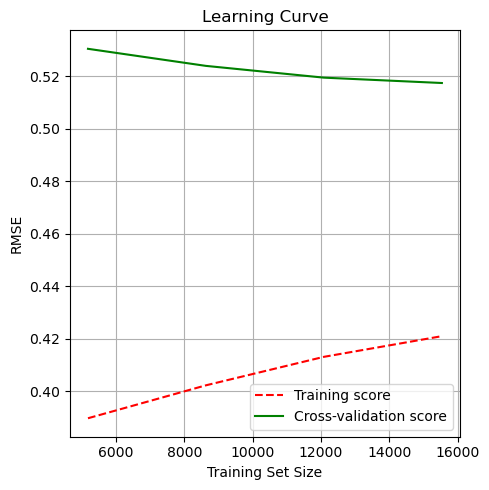

<module 'matplotlib.pyplot' from '/home/astolfo/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [28]:


lc_plot(Rdm_forest,Xtv,ytv)



## Analisis de los modelos

In [58]:
result_df_copy=result_df.copy()